<a href="https://colab.research.google.com/github/P4ttyCakes/SegmentAl/blob/main/DeepV3_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Saving DeWatermark.ai_1739066842519.png to DeWatermark.ai_1739066842519 (1).png


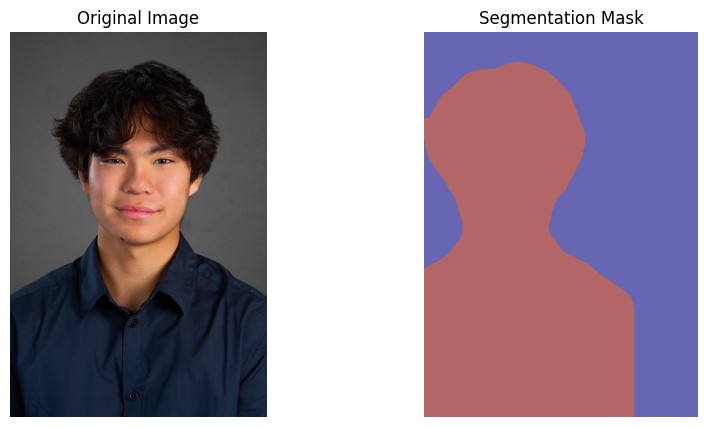

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from google.colab import files

def add_padding(image, target_size=(520, 520)):
    """Adds equal padding on both sides to make the image square while maintaining aspect ratio."""
    w, h = image.size
    max_dim = max(w, h)
    delta = abs(w - h) // 2

    if w < h:
        padding = (delta, 0, delta, 0)  # Equal padding on left and right
    else:
        padding = (0, delta, 0, delta)  # Equal padding on top and bottom

    return ImageOps.expand(image, padding, fill=(0, 0, 0)), padding

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    padded_image, padding = add_padding(image)

    transform = transforms.Compose([
        transforms.Resize((520, 520)),  # Resize after padding
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(padded_image).unsqueeze(0), padding, image

def remove_padding(segmentation_mask, original_size, padding):
    """Removes padding from the segmentation mask."""
    w, h = original_size
    return segmentation_mask[padding[1]:padding[1]+h, padding[0]:padding[0]+w]

def visualize_segmentation(image_path, model):
    input_tensor, padding, original_image = preprocess_image(image_path)
    with torch.no_grad():
        output = model(input_tensor)['out'][0]

    output_predictions = output.argmax(0).byte().cpu().numpy()
    output_predictions = remove_padding(output_predictions, original_image.size, padding)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(output_predictions, cmap='jet', alpha=0.6)
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    plt.show()

# Load model
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Load the uploaded image
torch.set_grad_enabled(False)
visualize_segmentation(image_path, model)